## Reduced variance emulator on the Australia20 sim suite

Experiment with emulating $kP_{1D}(k)/(1+z)^{3.8}$ instead in order to reduce the dependence of the underlying function on $z$ and $k$


In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
test_sim_num=16
skewers_label='Ns500_wM0.05'
#skewers_label=None
#basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
basedir="/p1d_emulator/sim_suites/Australia20/"
p1d_label=None
undersample_z=12
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

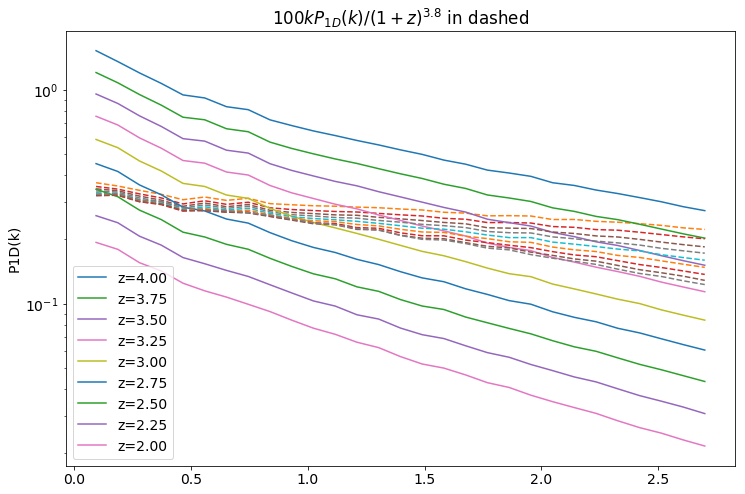

In [5]:
## What we were emulating before: P1D(k)
plt.figure(figsize=(12,8))
plt.title(r"$100kP_{1D}(k)/(1+z)^{3.8}$ in dashed")
for item in truth.data:
    plt.plot(item["k_Mpc"][1:30],item["p1d_Mpc"][1:30],label="z=%.2f" % item["z"])
    #plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*item["k_Mpc"][1:30]*item["p1d_Mpc"][1:30]),linestyle="dashed")
    plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*((1+item["k_Mpc"][1:30]))*item["p1d_Mpc"][1:30]),linestyle="dashed")
plt.yscale("log")
plt.legend()
plt.ylabel("P1D(k)")
plt.show()

In [6]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


In [7]:
arxiv_tau=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=False,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [8]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


In [9]:
emu_red=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var=True)

Training GP on 261 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [10]:
emu_tau=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv_tau,
                                reduce_var=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 783 points
Optimised


In [11]:
#emu_tau.load_hyperparams(emu_red.gp.param_array,emu_red.paramLimits)

In [12]:
mean=np.empty(len(emu_red.training_k_bins)-1)
std=np.empty(len(emu_red.training_k_bins)-1)
mean_red=np.empty(len(emu_red.training_k_bins)-1)
std_red=np.empty(len(emu_red.training_k_bins)-1)
for aa in range(1,len(emu_red.training_k_bins)):
    mean[aa-1]=np.mean(emu.normspectra[:,aa])
    std[aa-1]=np.std(emu.normspectra[:,aa])
    mean_red[aa-1]=np.mean(emu_red.normspectra[:,aa])
    std_red[aa-1]=np.std(emu_red.normspectra[:,aa])

Text(0, 0.5, 'Variance in training function')

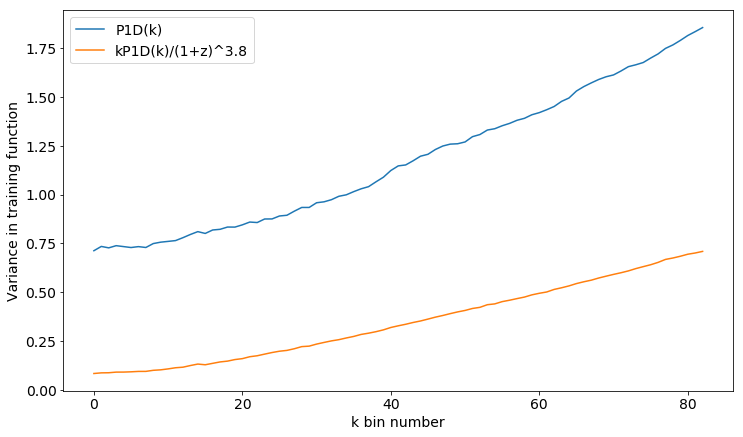

In [13]:
plt.figure(figsize=[12,7])
plt.plot(std,label="P1D(k)")
plt.plot(std_red,label="kP1D(k)/(1+z)^3.8")
plt.xlabel("k bin number")
plt.legend()
plt.ylabel("Variance in training function")

[0.01154583 0.01290658 0.00995091 0.00957898 0.0098233  0.00673896
 0.00560274 0.00574367 0.00794813 0.00637135 0.00538319 0.00575043
 0.00539408 0.00484728 0.00372872 0.00324949 0.00446901 0.00349686
 0.00241942 0.00331936 0.00220918 0.00391172 0.00393627 0.00216972
 0.00296255 0.00275344 0.00295468 0.00249179 0.00176712 0.00169497
 0.00255129 0.00302418 0.00295297 0.00178944 0.00224489 0.00261996
 0.00247484 0.00190109 0.00208767 0.00085281 0.00188591 0.00161896
 0.00119238 0.00167439 0.00149228 0.00170812 0.00120002 0.00108298
 0.00103139 0.00144345 0.00124593 0.00140222 0.00074423 0.0012731
 0.00117113 0.00071196 0.00113608 0.00106987 0.00104697 0.00073895
 0.00050612 0.00066427 0.00094247 0.00078928 0.00089709 0.00054432
 0.00079483 0.00028104 0.00082852 0.0006318  0.00025373 0.00047272
 0.00059337 0.00031897 0.00034482]
[0.01082129 0.0111301  0.0084581  0.00779145 0.00859453 0.00586413
 0.00453634 0.00509062 0.00652976 0.0056033  0.00464687 0.00517983
 0.00459548 0.00446214 0.003

Text(0.5, 132.40000000000015, 'k 1/Mpc')

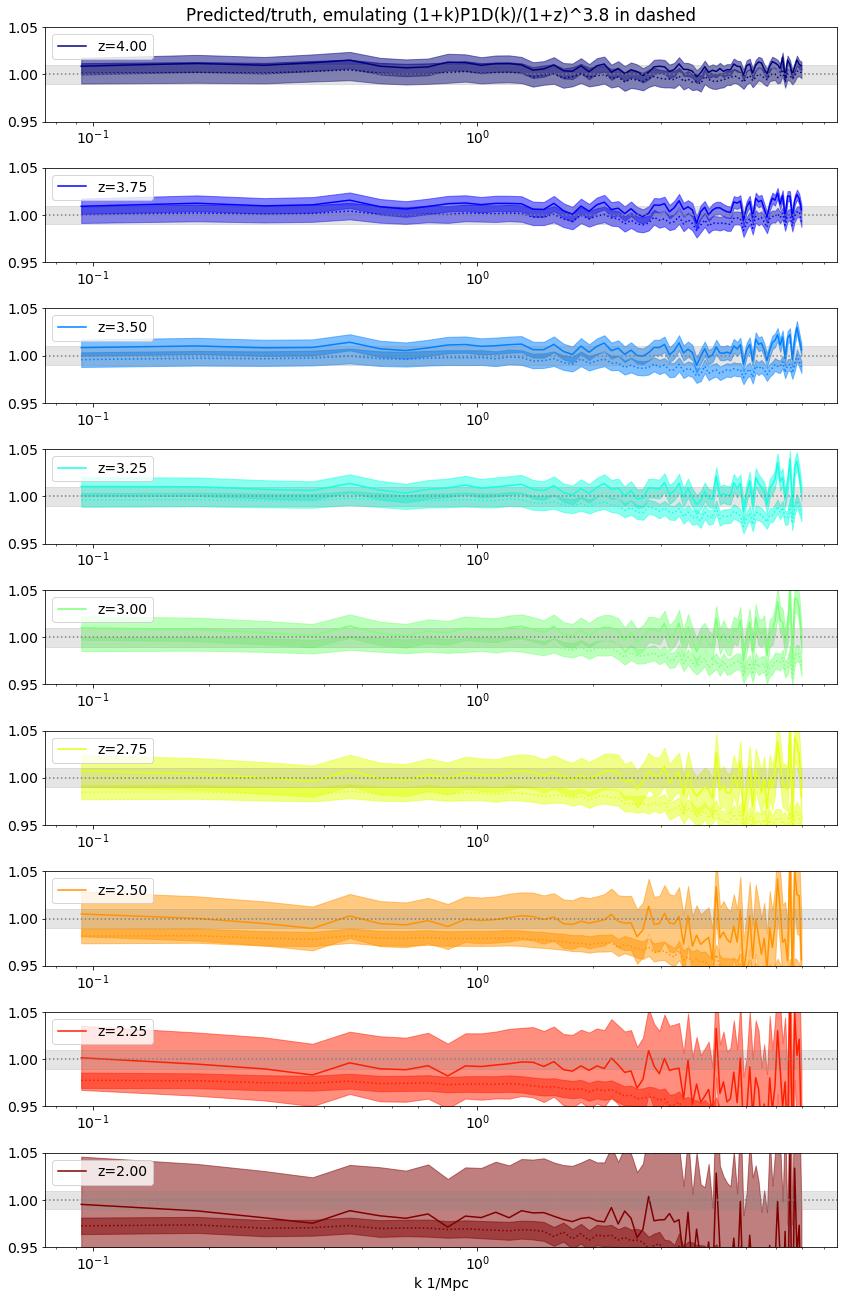

In [14]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_red.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred,color=col,label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau,color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau/item["p1d_Mpc"][2:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")
#plt.savefig("reduced_var_k.pdf")

Text(0.5, 132.40000000000015, 'k 1/Mpc')

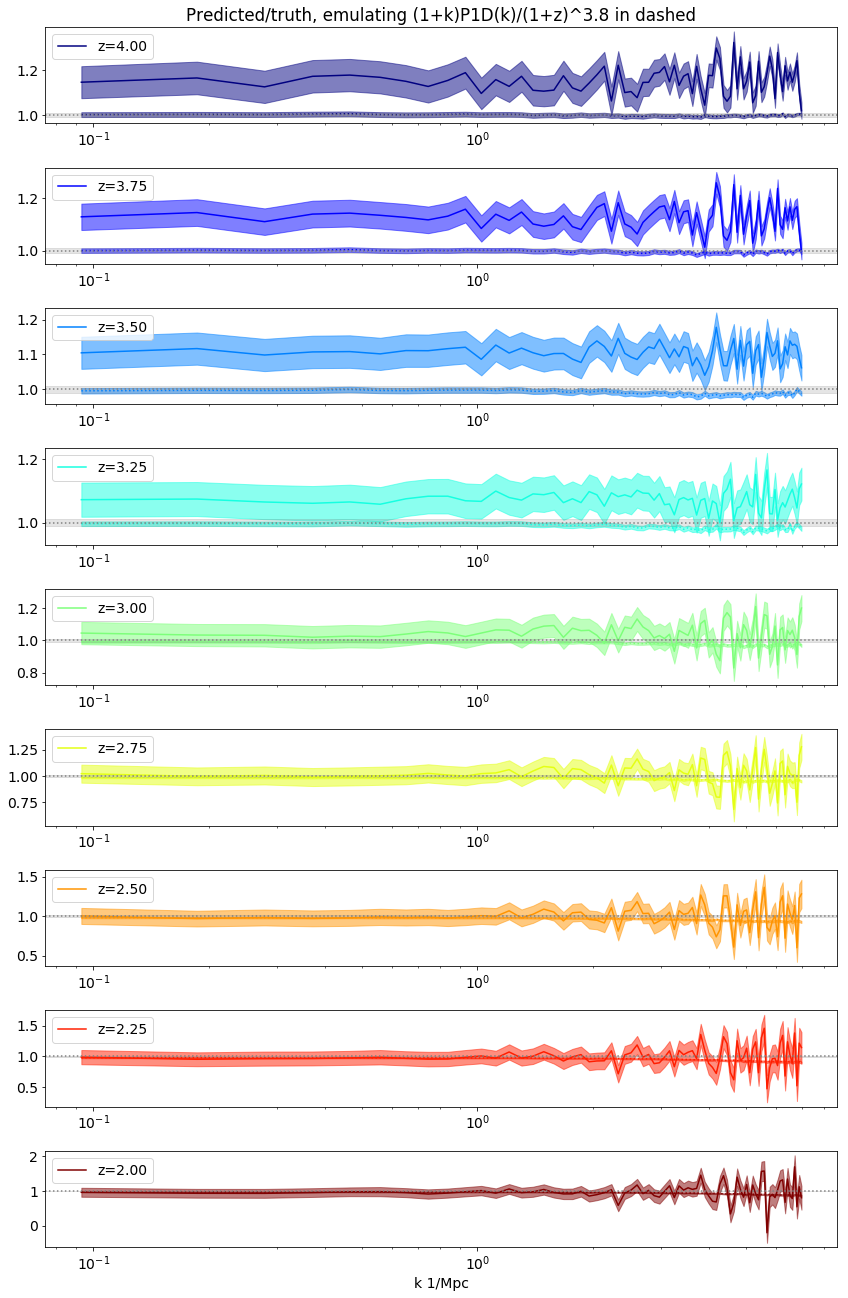

In [15]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu_tau.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_red.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])#
    #print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred,color=col,label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau,color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau/item["p1d_Mpc"][2:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    #plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")
#plt.savefig("reduced_var_k.pdf")

In [16]:
emu.gp.param_array

array([2.50476861e+01, 2.82171850e+01, 1.07176400e+00, 6.54648608e-06])

In [17]:
emu_red.gp.param_array

array([2.02446375e-01, 2.36876778e+00, 9.70281403e-01, 5.91457035e-06])

In [18]:
emu_tau.gp.param_array

array([2.34719433e+00, 1.14113938e+00, 3.67867318e-01, 3.00492886e-16])

In [19]:
emu_tau.paramLimits

array([[ 0.26701081,  0.88314482],
       [ 0.08785083,  0.15489765],
       [ 1.12802305,  1.82432761],
       [ 7.90431314, 15.63489649],
       [ 0.16315329,  0.78107033],
       [-2.34833374, -2.25166652]])

In [20]:
emu_red.paramLimits

array([[ 0.28531175,  0.87511504],
       [ 0.08785083,  0.15489765],
       [ 1.12802305,  1.82432761],
       [ 7.90431314, 15.63489649],
       [ 0.16315329,  0.78107033],
       [-2.34833374, -2.25166652]])

In [21]:
mean=np.empty(len(emu_red.training_k_bins)-1)
std=np.empty(len(emu_red.training_k_bins)-1)
mean_red=np.empty(len(emu_red.training_k_bins)-1)
std_red=np.empty(len(emu_red.training_k_bins)-1)
for aa in range(1,len(emu_red.training_k_bins)):
    mean[aa-1]=np.mean(emu.normspectra[:,aa])
    std[aa-1]=np.std(emu.normspectra[:,aa])
    mean_red[aa-1]=np.mean(emu_red.normspectra[:,aa])
    std_red[aa-1]=np.std(emu_red.normspectra[:,aa])

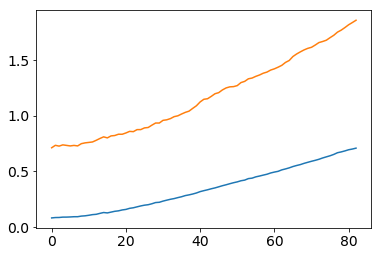

In [22]:
plt.plot(std_red)
plt.plot(std)

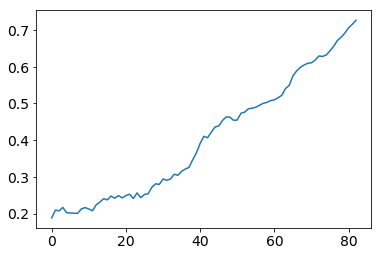

In [23]:
plt.plot(mean)

In [24]:
emu_red.scalefactors

array([0.00330443, 0.00323467, 0.00304569, 0.00293999, 0.00275799,
       0.00284102, 0.00275735, 0.00280564, 0.00265332, 0.00259722,
       0.00254352, 0.00252714, 0.00247668, 0.00243709, 0.00237507,
       0.00233261, 0.00229548, 0.00225065, 0.00217218, 0.00215907,
       0.00211404, 0.00204019, 0.00199788, 0.00196228, 0.00191238,
       0.00186929, 0.00182036, 0.00177028, 0.00171642, 0.00167177,
       0.00162415, 0.00157771, 0.0015372 , 0.00148936, 0.00144462,
       0.00140982, 0.00136406, 0.00132441, 0.00128432, 0.00124415,
       0.0012027 , 0.00116229, 0.00112115, 0.00108725, 0.00105186,
       0.00102071, 0.00098466, 0.00095022, 0.0009195 , 0.00088786,
       0.00085885, 0.00083073, 0.00080066, 0.00077774, 0.00074788,
       0.00072936, 0.00070248, 0.00068054, 0.00065876, 0.00063698,
       0.00061663, 0.00059466, 0.00057589, 0.00055325, 0.00053403,
       0.00051464, 0.00049374, 0.00047727, 0.00046201, 0.00044554,
       0.00042987, 0.00041555, 0.00040274, 0.00038942, 0.00037

In [25]:
old_red=array([3.23445903e-02, 2.56384752e+00, 9.69125651e-01, 6.03394572e-06])

NameError: name 'array' is not defined